In [2]:
import numpy as np
import matplotlib.pyplot as plt
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [3]:
sample_rate = 4096

## Functions

In [24]:
def get_anomaly_matches(fid_params, trial_params, n, n_data, n_match=None, f_match=20):

    # Setup
    if n_match is None or n_match > n:
        n_match = n
    harm_ids = [0]
    data = {'anomaly':[], 'h0':[]}
    for i in range(1, n_match):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)
        data[f'h{harm_ids[-1]}'] = []
    
    # Get fiducial waveform harmonics
    all_wfs = list(get_h([1]*n, fid_params['f_low'], fid_params['e'], chirp2total(fid_params['chirp'], fid_params['q']),
                         fid_params['q'], sample_rate))
    harm_wfs = all_wfs[1:n_match+1]

    # Get shifted param values
    s_f_2pi = trial_params['f_low'] - shifted_f(trial_params['f_low'], trial_params['e'], 
                                                chirp2total(trial_params['chirp'], trial_params['q']), trial_params['q'])
    anomaly_ints = np.arange(n_data-1, -1, -1)
    s_f_vals = trial_params['f_low'] - anomaly_ints*s_f_2pi/n_data
    s_e_vals = shifted_e(s_f_vals, trial_params['f_low'], trial_params['e'])

    # Calculate matches for each trial wf
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Generate trial waveform
        h = gen_wf(s_f, s_e, chirp2total(trial_params['chirp'], trial_params['q']),
                   trial_params['q'], sample_rate, 'TEOBResumS')

        # Calculate psd for first trial (as longest wf)
        if i == 0:
            if len(harm_wfs[0]) > len(h):
                psd = gen_psd(harm_wfs[0], trial_params['f_low'])
            else:
                psd = gen_psd(h, trial_params['f_low'])

        # Calculate matches
        match_cplx = match_hn(harm_wfs, h, trial_params['f_low'], psd=psd)

        # Save data
        data['anomaly'].append(-2*np.pi*anomaly_ints[i]/n_data)
        for j, harm_id in enumerate(harm_ids):
            data[f'h{harm_id}'].append(np.abs(match_cplx[j]))

        print(f'\r{i+1} done out of {n_data}.', end='')
    print('')

    return data

In [25]:
def get_phase_matches(fid_params, trial_params, n, n_data, n_match=None, f_match=20):

    # Setup
    if n_match is None or n_match > n:
        n_match = n
    harm_ids = [0]
    data = {'phase':[], 'h0':[]}
    for i in range(1, n_match):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)
        data[f'h{harm_ids[-1]}'] = []
    
    # Get fiducial waveform harmonics
    all_wfs = list(get_h([1]*n, fid_params['f_low'], fid_params['e'], chirp2total(fid_params['chirp'], fid_params['q']),
                         fid_params['q'], sample_rate))
    harm_wfs = all_wfs[1:n_match+1]

    # Get shifted param values
    phase_vals = 2*np.pi*np.arange(n_data)/n_data

    # Calculate matches for each trial wf
    for i, phase in enumerate(phase_vals):

        # Generate trial waveform
        h = gen_wf(trial_params['f_low'], trial_params['e'], chirp2total(trial_params['chirp'], trial_params['q']),
                   trial_params['q'], sample_rate, 'TEOBResumS', phase=phase)

        # Calculate psd for first trial (as longest wf)
        if i == 0:
            if len(harm_wfs[0]) > len(h):
                psd = gen_psd(harm_wfs[0], trial_params['f_low'])
            else:
                psd = gen_psd(h, trial_params['f_low'])

        # Calculate matches
        match_cplx = match_hn(harm_wfs, h, trial_params['f_low'], psd=psd)

        # Save data
        data['phase'].append(phase)
        for j, harm_id in enumerate(harm_ids):
            data[f'h{harm_id}'].append(np.abs(match_cplx[j]))

        print(f'\r{i+1} done out of {n_data}.', end='')
    print('')

    return data

In [26]:
def get_polarisation_matches(fid_params, trial_params, n, n_data, n_match=None, f_match=20):

    # Setup
    if n_match is None or n_match > n:
        n_match = n
    harm_ids = [0]
    data = {'polarisation':[], 'h0':[]}
    for i in range(1, n_match):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)
        data[f'h{harm_ids[-1]}'] = []
    
    # Get fiducial waveform harmonics
    all_wfs = list(get_h([1]*n, fid_params['f_low'], fid_params['e'], chirp2total(fid_params['chirp'], fid_params['q']),
                         fid_params['q'], sample_rate))
    harm_wfs = all_wfs[1:n_match+1]

    # Get shifted param values
    polarisation_vals = 2*np.pi*np.arange(n_data)/n_data

    # Generate trial waveform
    h_trial = gen_wf(trial_params['f_low'], trial_params['e'], chirp2total(trial_params['chirp'], trial_params['q']),
               trial_params['q'], sample_rate, 'TEOBResumS')

    # Calculate matches for each trial wf
    for i, polarisation in enumerate(polarisation_vals):

        # Generate trial waveform
        h = h_trial*np.e**(2*1j*polarisation)

        # Calculate psd for first trial (as longest wf)
        if i == 0:
            if len(harm_wfs[0]) > len(h):
                psd = gen_psd(harm_wfs[0], trial_params['f_low'])
            else:
                psd = gen_psd(h, trial_params['f_low'])

        # Calculate matches
        match_cplx = match_hn(harm_wfs, h, trial_params['f_low'], psd=psd)

        # Save data
        data['polarisation'].append(polarisation)
        for j, harm_id in enumerate(harm_ids):
            data[f'h{harm_id}'].append(np.abs(match_cplx[j]))

        print(f'\r{i+1} done out of {n_data}.', end='')
    print('')

    return data

In [27]:
def get_inclination_matches(fid_params, trial_params, n, n_data, n_match=None, f_match=20):

    # Setup
    if n_match is None or n_match > n:
        n_match = n
    harm_ids = [0]
    data = {'inclination':[], 'h0':[]}
    for i in range(1, n_match):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)
        data[f'h{harm_ids[-1]}'] = []
    
    # Get fiducial waveform harmonics
    all_wfs = list(get_h([1]*n, fid_params['f_low'], fid_params['e'], chirp2total(fid_params['chirp'], fid_params['q']),
                         fid_params['q'], sample_rate))
    harm_wfs = all_wfs[1:n_match+1]

    # Get shifted param values
    inclination_vals = 2*np.pi*np.arange(n_data)/n_data

    # Calculate matches for each trial wf
    for i, inclination in enumerate(inclination_vals):

        # Generate trial waveform
        h = gen_wf(trial_params['f_low'], trial_params['e'], chirp2total(trial_params['chirp'], trial_params['q']),
                         trial_params['q'], sample_rate, 'TEOBResumS', inclination=inclination)

        # Calculate psd for first trial (as longest wf)
        if i == 0:
            if len(harm_wfs[0]) > len(h):
                psd = gen_psd(harm_wfs[0], trial_params['f_low'])
            else:
                psd = gen_psd(h, trial_params['f_low'])

        # Calculate matches
        match_cplx = match_hn(harm_wfs, h, trial_params['f_low'], psd=psd)

        # Save data
        data['inclination'].append(inclination)
        for j, harm_id in enumerate(harm_ids):
            data[f'h{harm_id}'].append(np.abs(match_cplx[j]))

        print(f'\r{i+1} done out of {n_data}.', end='')
    print('')

    return data

In [28]:
def plot_matches(data, title, key):

    # Plot unnormalised matches
    plt.plot(data[key], data['h0'], c='C0', label='h0')
    plt.plot(data[key], data['h1'], c='C1', label='h1')
    plt.plot(data[key], data['h-1'], c='C2', label='h-1')
    plt.plot(data[key], np.sqrt(np.array(data['h1'])**2+np.array(data['h-1'])**2),
             c='C3', ls='dashed', label='(h1, h-1)')

    # Plot formatting
    plt.legend()
    plt.title(title)
    plt.xlabel(key)
    plt.ylabel('match')
    plt.xlim(np.min(data[key]), np.max(data[key]))
    plt.ylim(0,1)
    plt.show()

    # Plot matches divided by h0
    plt.plot(data[key], np.array(data['h1'])/np.array(data['h0']), c='C1', label='h1/h0')
    plt.plot(data[key], np.array(data['h-1'])/np.array(data['h0']), c='C2', label='h-1/h0')
    plt.plot(data[key], np.sqrt(np.array(data['h1'])**2+np.array(data['h-1'])**2)/np.array(data['h0']),
             c='C3', ls='dashed', label='(h1, h-1)/h0')

    # Plot formatting
    plt.legend()
    plt.title(title)
    plt.xlabel(key)
    plt.ylabel('match ratio')
    plt.xlim(np.min(data[key]), np.max(data[key]))
    plt.ylim(0,)
    plt.show()

# 24 chirp mass

## Low fid, low trial (e_10 = 0.1, 0.1)

In [26]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
data_0 = get_anomaly_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


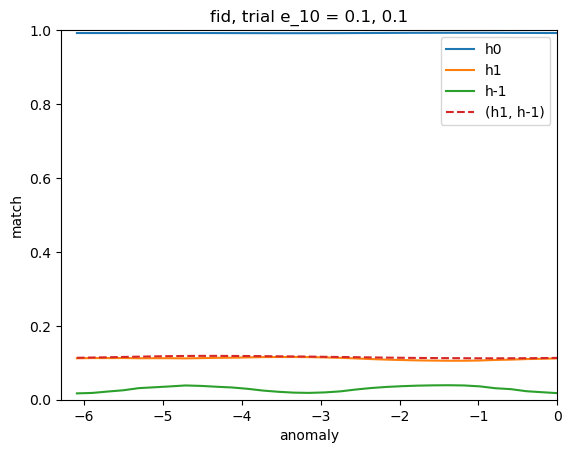

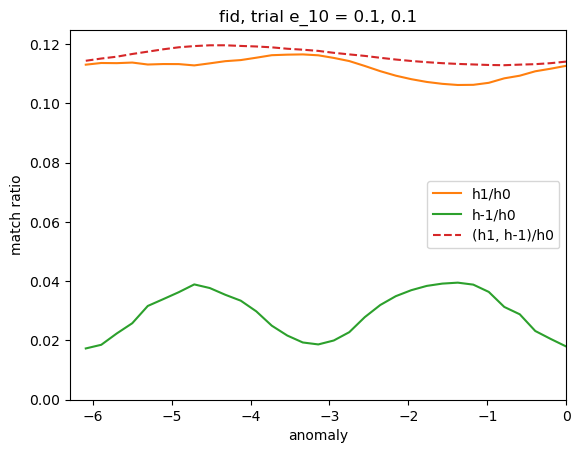

In [27]:
plot_matches(data_0, 'fid, trial e_10 = 0.1, 0.1', 'anomaly')

## Low fid, high trial (e_10 = 0.1, 0.3)

In [7]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(24, 0.3), 'q': 2}
data_1 = get_anomaly_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


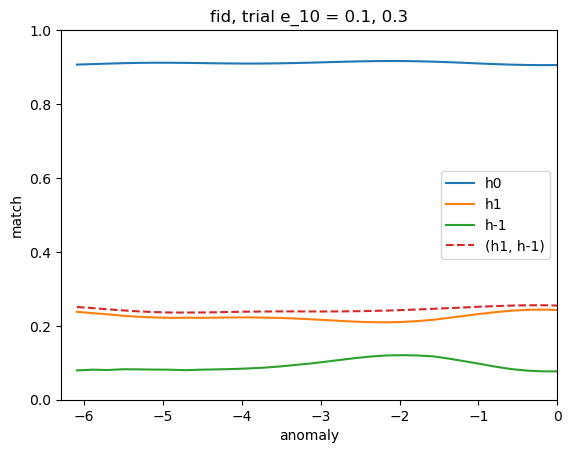

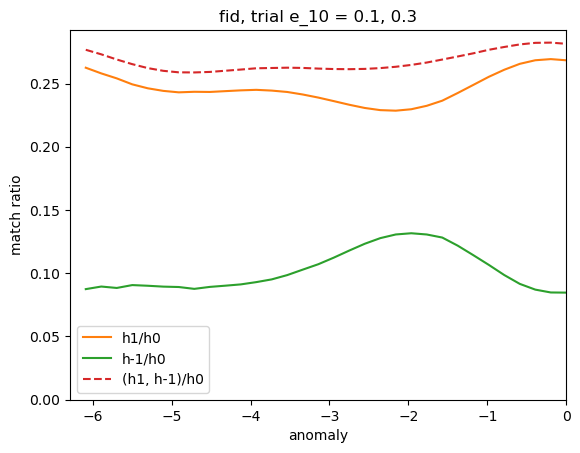

In [8]:
plot_matches(data_1, 'fid, trial e_10 = 0.1, 0.3', 'anomaly')

## High fid, high trial (e_10 = 0.3, 0.3)

In [29]:
fid_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(24, 0.3), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(24, 0.3), 'q': 2}
data_2 = get_anomaly_matches(fid_params, trial_params, 10, 32)

32 done out of 32.


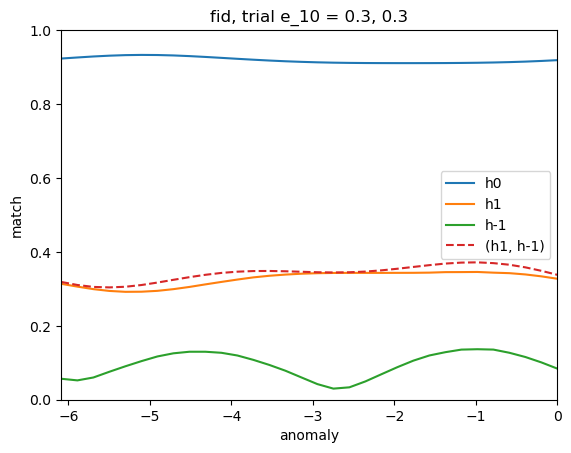

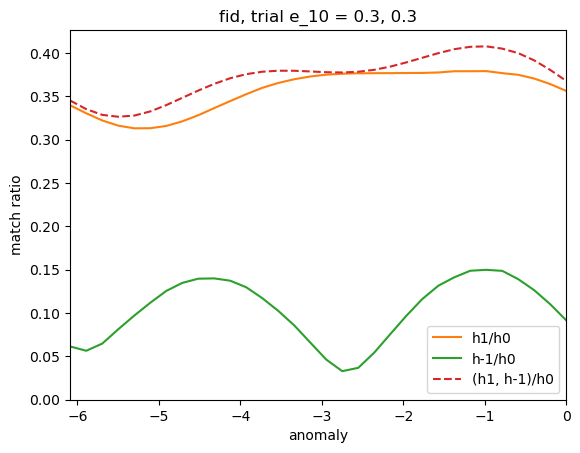

In [30]:
plot_matches(data_2, 'fid, trial e_10 = 0.3, 0.3', 'anomaly')

# 10 chirp mass

## Low fid, low trial (e_10 = 0.1, 0.1)

In [17]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(10, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(10, 0.1), 'q': 2}
data_3 = get_anomaly_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


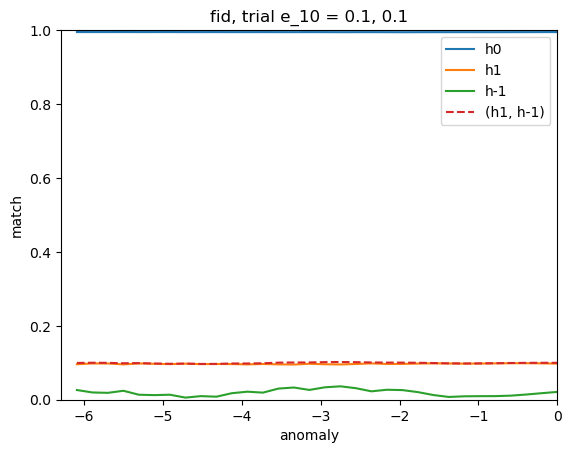

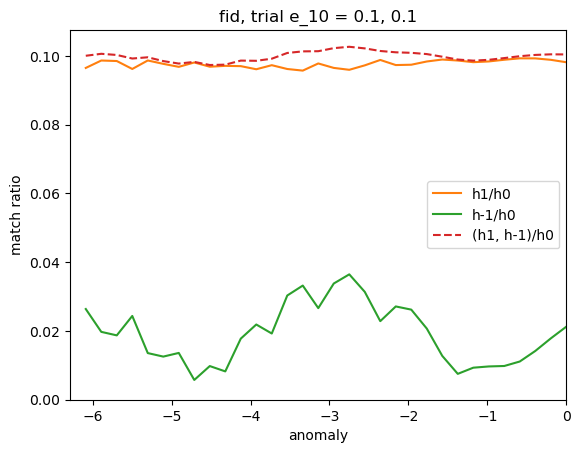

In [18]:
plot_matches(data_3, 'fid, trial e_10 = 0.1, 0.1', 'anomaly')

## Low fid, high trial (e_10 = 0.1, 0.3)

In [19]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(10, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(10, 0.3), 'q': 2}
data_4 = get_anomaly_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


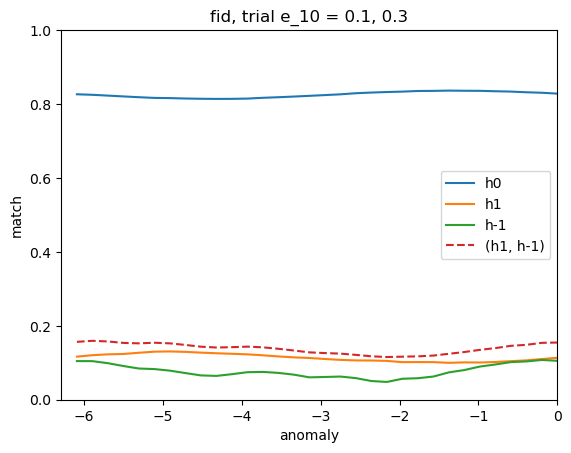

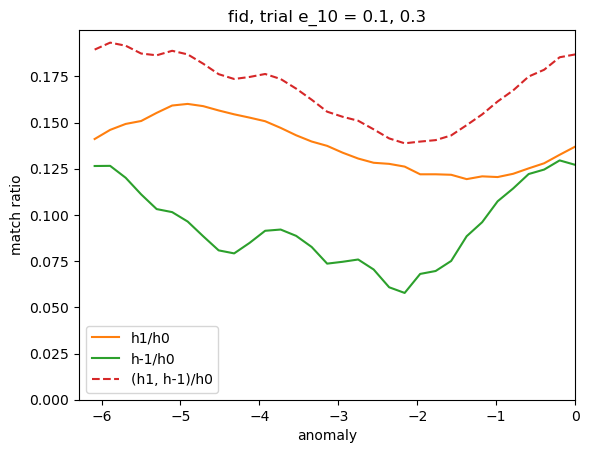

In [20]:
plot_matches(data_4, 'fid, trial e_10 = 0.1, 0.3', 'anomaly')

## High fid, high trial (e_10 = 0.3, 0.3)

In [31]:
fid_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(10, 0.3), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.3, 'chirp': chirp_degeneracy_line(10, 0.3), 'q': 2}
data_5 = get_anomaly_matches(fid_params, trial_params, 10, 32)

32 done out of 32.


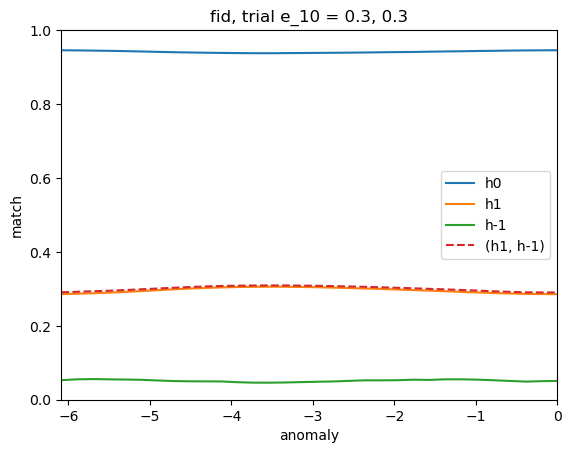

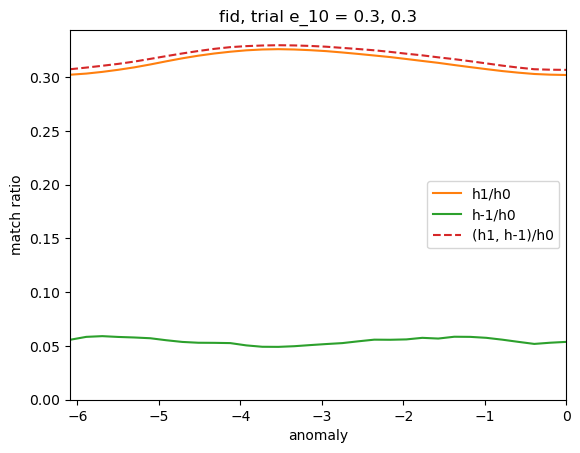

In [32]:
plot_matches(data_5, 'fid, trial e_10 = 0.3, 0.3', 'anomaly')

# Phase, polarisation, and inclination

In [32]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
data_6 = get_phase_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


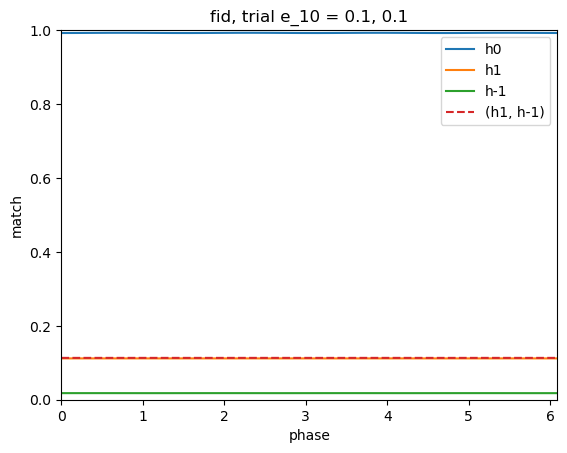

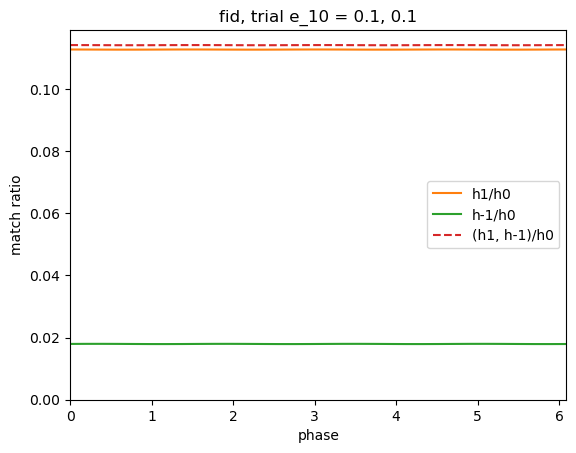

In [33]:
plot_matches(data_6, 'fid, trial e_10 = 0.1, 0.1', 'phase')

In [35]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
data_7 = get_polarisation_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


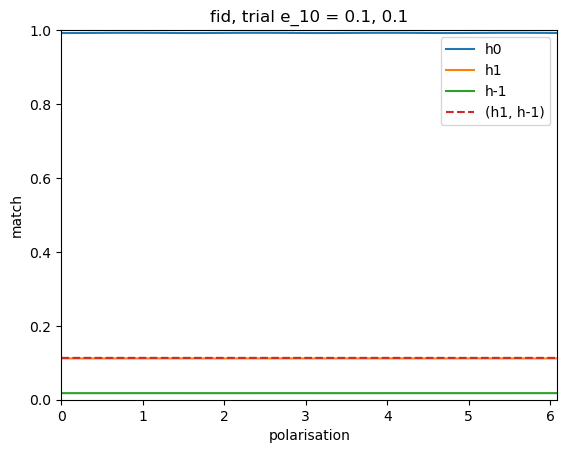

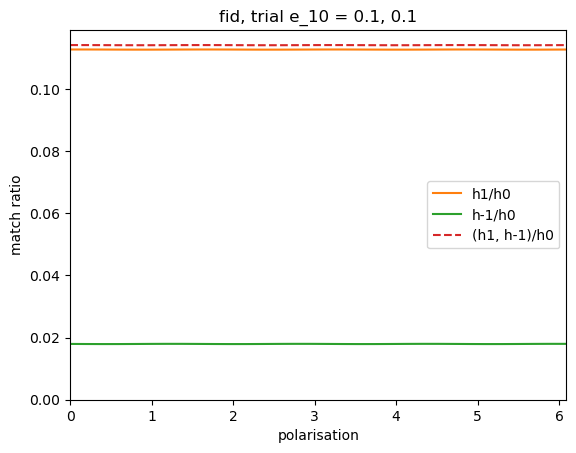

In [36]:
plot_matches(data_7, 'fid, trial e_10 = 0.1, 0.1', 'polarisation')

In [6]:
fid_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
trial_params = {'f_low': 10, 'e': 0.1, 'chirp': chirp_degeneracy_line(24, 0.1), 'q': 2}
data_8 = get_inclination_matches(fid_params, trial_params, 4, 32)

32 done out of 32.


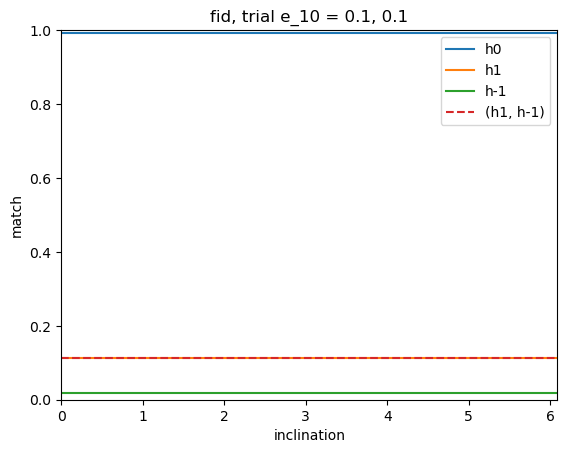

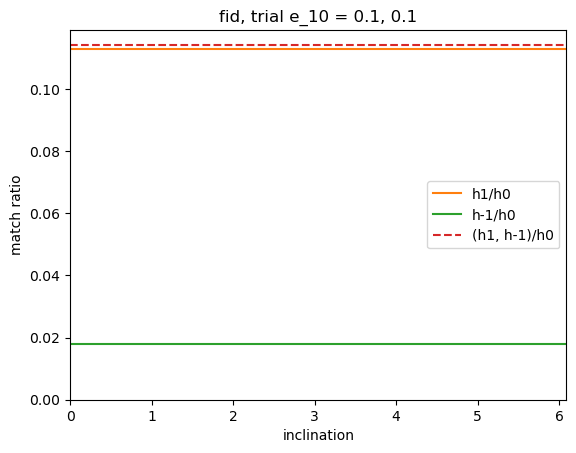

In [9]:
plot_matches(data_8, 'fid, trial e_10 = 0.1, 0.1', 'inclination')